In [19]:
# import libraries
import numpy as np
import pandas as pd
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import re

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# load in directories
from experiment_code.constants import Defaults

In [20]:
# load in data from gorilla
df = pd.read_csv(os.path.join(Defaults.RAW_DIR, "gorilla_v3.csv"))

## Clean up data and concatenate

In [21]:
# filter dataframe to remove redundant cols
df_filtered = df.filter({'Experiment ID', 'Experiment Version', 'Task Version', 'Participant Private ID',
           'counterbalance-mpke', 'Spreadsheet Row', 'Zone Type', 
           'Reaction Time', 'Response', 'display', 'iti_dur_ms', 
           'trial_dur_ms', 'V1', 'V2', 'V2', 'V3', 'V4', 'V5',
          'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12'})

In [22]:
# clean spreadsheet
df_filtered = df_filtered.rename({'Zone Type':'Zone_Type'}, axis=1)
df_filtered = df_filtered.rename({'Participant Private ID':'Participant_Private_ID'}, axis=1)
df_filtered.columns

Index(['V2', 'Response', 'V5', 'V4', 'V8', 'iti_dur_ms', 'V1', 'V10',
       'Participant_Private_ID', 'counterbalance-mpke', 'V3',
       'Experiment Version', 'V9', 'trial_dur_ms', 'V12', 'V7',
       'Spreadsheet Row', 'Task Version', 'Experiment ID', 'Zone_Type', 'V6',
       'V11', 'Reaction Time', 'display'],
      dtype='object')

In [24]:
# select response-only rows and re-index
df_filtered = df_filtered.query('Zone_Type=="response_rating_scale_likert"')
df_filtered = df_filtered.reset_index()
del df_filtered['index']

## Investigate and remove outliers

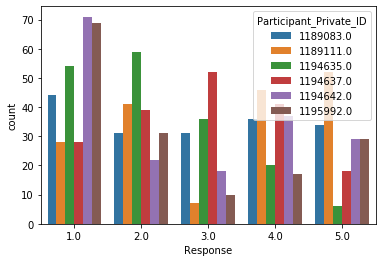

In [32]:
#Investigate Outliers 

def distribution_of_participants_per_version(version):
    "Gives distribution of scores for each participant of a particular version (where x='version', i.e. V1, V2, etc)"
    df_filtered_version = df_filtered.loc[df_filtered['counterbalance-mpke'] == version]
    df_filtered_version.Participant_Private_ID.unique()
    return sns.countplot(x='Response', hue='Participant_Private_ID', data= df_filtered_version)
    
distribution_of_participants_per_version("V1")

In [27]:
# Drop Outlier in V12
df_where_outlier_2 = df_filtered[df_filtered.Participant_Private_ID == 1194659.0]
print(df_where_outlier_2.index)
df_final_filtered = df_filtered.drop(df_filtered.index[9434:9612])
df_final_filtered.count

Int64Index([9434, 9435, 9436, 9437, 9438, 9439, 9440, 9441, 9442, 9443,
            ...
            9602, 9603, 9604, 9605, 9606, 9607, 9608, 9609, 9610, 9611],
           dtype='int64', length=178)


<bound method DataFrame.count of                                                       V2  Response  \
0       Amber missed the bus even though she yelled stop       1.0   
1      A village was discovered between the mountains...       3.0   
2      From the mountaintop, Wyatt could see the whol...       1.0   
3      The mountaineer spotted a small town in the op...       3.0   
4      When the rain started, the hikers ran into a cave       4.0   
...                                                  ...       ...   
10319  The market does not provide customers with a s...       1.0   
10320     The actress rolled her eyes and left in a huff       5.0   
10321  Frustrated with his teammates, Julian stormed ...       1.0   
10322  Upset with her brother's rudeness, Kelsey left...       2.0   
10323           As Aiden aged, he began to lose his hair       4.0   

                                                      V5  \
0        His brand new soccer ball had landed in the mud   
1     

In [28]:
# Re-Index 
df_final_filtered = df_final_filtered.reset_index()
del df_final_filtered['index']
df_final_filtered

,V2,Response,V5,V4,V8,iti_dur_ms,V1,V10,Participant_Private_ID,counterbalance-mpke,...,V12,V7,Spreadsheet Row,Task Version,Experiment ID,Zone_Type,V6,V11,Reaction Time,display
0,Amber missed the bus even though she yelled stop,1.0,His brand new soccer ball had landed in the mud,The landscaper went to the branch and started ...,Little Gracie said the most boring place ever ...,500.0,He hated bees and feared encountering a hive,The business owner was scared that his busines...,1189080.0,V8,...,"At noon, the grandfather clock began to loudly...",The farmer used the extra corn he had as feed,2.0,19.0,13726.0,response_rating_scale_likert,"While in the city, Amanda didn't feel safe",Abby stuck his picture to her wall with a tack,10000.64,trial
1,A village was discovered between the mountains...,3.0,The hiker's new boots were stuck in the deep mud,Tom carefully searched for a bolt of the right...,He was a sweet boy until he entered that school,500.0,Above the treehouse were the bees made their hive,Nina had no confidence and always expected to ...,1189080.0,V8,...,In the morning all the baby birds start to chirp,The worried mother had many mouths to feed,3.0,19.0,13726.0,response_rating_scale_likert,"At the hotel, Kevin kept his valuables in the ...",Frankie had four plants getting sunned on the ...,10000.40,trial
2,"From the mountaintop, Wyatt could see the whol...",1.0,"Distracted while driving, Maya got stuck in th...",I returned the dress because it was the wrong ...,The sugar content in Ivy's cake was too high,500.0,"After collecting the pollen, the bee returned ...",Some people are overconfident and claim they n...,1189080.0,V8,...,"In the morning, Kathy hoped that the birds wou...",Andrea watered her garden with a small hose,4.0,19.0,13726.0,response_rating_scale_likert,The skyscraper was demolished because it wasn'...,"After the rain stopped, Caroline played outsid...",10000.16,trial
3,The mountaineer spotted a small town in the op...,3.0,The farm worker collected fresh eggs from the ...,The football practice was canceled due to extr...,The newborn chickens spent the day following t...,500.0,There were hundreds of bees buzzing around the...,"When Sheldon is upset, others can hear his tee...",1189080.0,V8,...,In the summer she loved hearing the crickets c...,Fred only criticized Larry to make him feel bad,5.0,19.0,13726.0,response_rating_scale_likert,The robber ordered the bank teller to open the...,The minor damage to their car was from hail,10001.88,trial
4,"When the rain started, the hikers ran into a cave",4.0,The mother went to the preschool to pick up he...,"When Simon tore his pants, there was a loud rip",The farm animals were transported in a truck,500.0,The buzzing noise turned out to be from a bee,Paul disliked summer because of the humidity a...,1189080.0,V8,...,Sarah threw the dirty towel in the hamper,The healthorganic,6.0,19.0,13726.0,response_rating_scale_likert,Holly put her most expensive jewelry in the safe,His mother cautioned him about letting the ban...,10000.14,trial
5,The lucky explorers discovered diamonds in the...,5.0,"Though gruff to his friends, Hank wasn't to hi...",The dog ran inside just before it started to rain,The scared girl ran upstairs to her bedroom an...,500.0,The infant cried when she got stung by a bee,The man said he fainted because of the heat,1189080.0,V8,...,"In woodshop, Alex smoothed the baseball bat wi...",Growing up with three brothers made Maddy tough,7.0,19.0,13726.0,response_rating_scale_likert,"Terry wanted to skip school, but she wouldn't ...",Terry told Jay the old fruit had begun to rot,10001.32,trial
6,"During the winter, the bear slept in its cave",3.0,Her father said the most important people are ...,The couple's trip was ruined when it began to ...,"During the thunderstorm, the dog entered the c...",500.0,The boy screamed after he was stung by a bee,Her grandmother told her she was sweet as a pie,1189080.0,V8,...,Jamie preferred to use cooking foil made of al...,She g

## Visualizations

## Distribution of versions

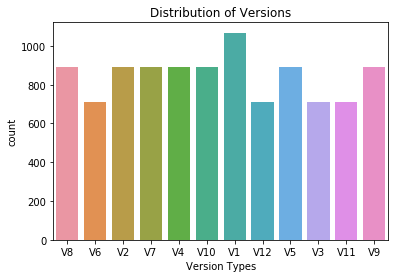

In [29]:
sns.countplot(x='counterbalance-mpke', data=df_final_filtered)
plt.xlabel('Version Types')
plt.title('Distribution of Versions');
# Therefore, V3, V6, V8, V11, and V12 (n=4); V2, V4, V5, V7, V9, & V10 (n=5) ;V1 (n=6)

## Distribution of CoRT scores

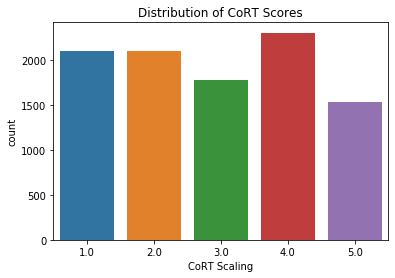

In [30]:
sns.countplot(x='Response', data=df_final_filtered)
plt.xlabel('CoRT Scaling')
plt.title('Distribution of CoRT Scores');

## Distrubution of CoRT scores broken down by version

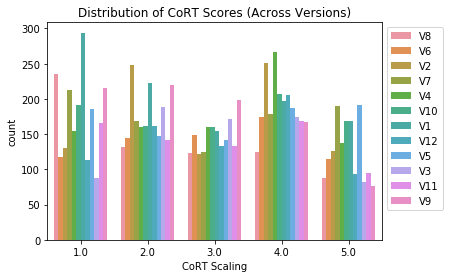

In [31]:
ax = sns.countplot(x='Response', hue='counterbalance-mpke', data=df_final_filtered)
ax.legend(loc='best', bbox_to_anchor=(1,1))
plt.xlabel('CoRT Scaling')
plt.title('Distribution of CoRT Scores (Across Versions)');

## Calculate SDs for each item

## Incorporate cloze probabilities

## Select for final sentences